# Continuous Control


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_single_agent.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


As explained in the Navigation notebook, environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. As mentioned in the instructions, a reward of `+0.1` is provided for each time step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

### 4. Implementation

 When training the environment, we set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
# Import the plotting function
%matplotlib inline
from utils import plot_scores

#### 4.1. Instantiate the Agent

In [6]:
from  ddpg_gen_agent import Agent
agent = Agent(state_size=33, action_size=4, seed=234)

#### 4.2 Define the ddpg algorithm

In [7]:
from collections import deque
import numpy as np
import torch
def ddpg(n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, attempt=None):
    """Deep DPG
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start: noise decay start
        eps_end: terminal noise decay
        eps_decay: decay rate per episode
        
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start
    attain_max = False
    low_bound = 30
    for i_episode in range(1, n_episodes+1):           
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] 
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment and brain
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]   # get the done status
            agent.step(state, action, reward, next_state, done) # Add to memory, and if enough steps, learn
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay * eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            # Add plots every 100 episodes
            plot_scores(scores, attempt, i_episode)
        if np.mean(scores_window)>=low_bound and attain_max==False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            attain_max = True
            low_bound = np.mean(scores_window)
        elif np.mean(scores_window) > low_bound:
            print('\nMaxium average achieved after {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_max.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_max.pth')
            low_bound = np.mean(scores_window)
    return scores





Episode 100	Average Score: 1.44


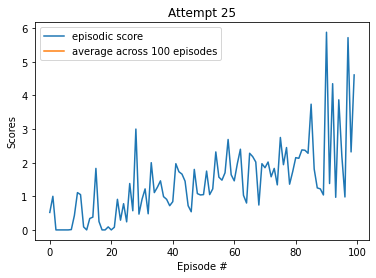

Episode 200	Average Score: 7.56


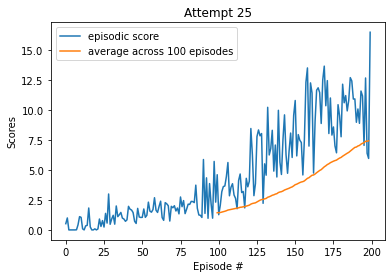

Episode 300	Average Score: 15.42


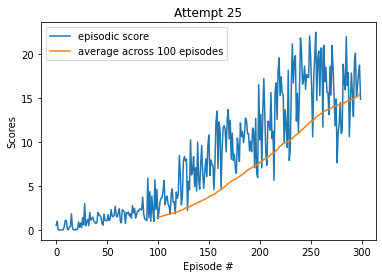

Episode 400	Average Score: 20.76


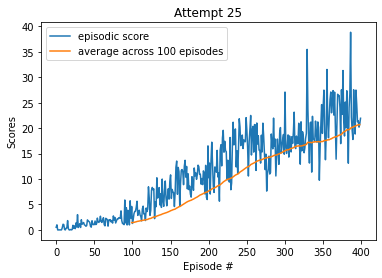

Episode 500	Average Score: 26.11


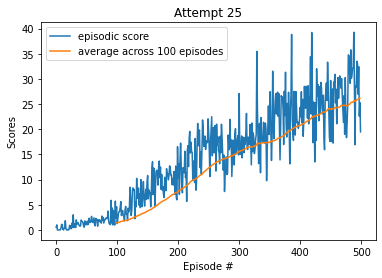

Episode 600	Average Score: 28.35


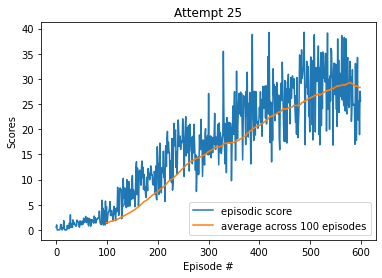

Episode 700	Average Score: 29.34


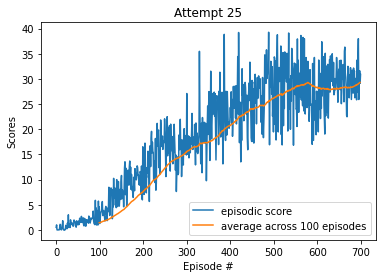

In [8]:
#### 4.3 Train the agent with the optimal parameters, as described in the report
scores = ddpg(700, attempt=25)

Clearly the agent is still learning, so we continue for another 300 epsiodes.
Note that the scores will only count after episode 100.

Episode 1	Average Score: 30.34
Environment solved in -99 episodes!	Average Score: 30.34
Episode 2	Average Score: 30.61
Maxium average achieved after 2 episodes!	Average Score: 30.61
Episode 100	Average Score: 28.68


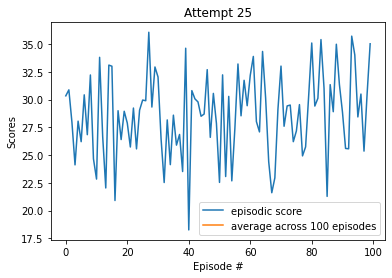

Episode 153	Average Score: 30.69
Maxium average achieved after 153 episodes!	Average Score: 30.69
Episode 165	Average Score: 30.69
Maxium average achieved after 165 episodes!	Average Score: 30.69
Episode 167	Average Score: 30.74
Maxium average achieved after 167 episodes!	Average Score: 30.74
Episode 168	Average Score: 30.74
Maxium average achieved after 168 episodes!	Average Score: 30.74
Episode 191	Average Score: 30.76
Maxium average achieved after 191 episodes!	Average Score: 30.76
Episode 192	Average Score: 30.85
Maxium average achieved after 192 episodes!	Average Score: 30.85
Episode 193	Average Score: 30.93
Maxium average achieved after 193 episodes!	Average Score: 30.93
Episode 198	Average Score: 30.94
Maxium average achieved after 198 episodes!	Average Score: 30.94
Episode 199	Average Score: 30.99
Maxium average achieved after 199 episodes!	Average Score: 30.99
Episode 200	Average Score: 30.92


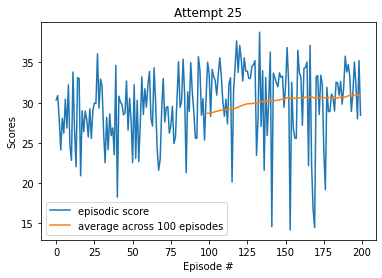

Episode 202	Average Score: 31.00
Maxium average achieved after 202 episodes!	Average Score: 31.00
Episode 300	Average Score: 30.19


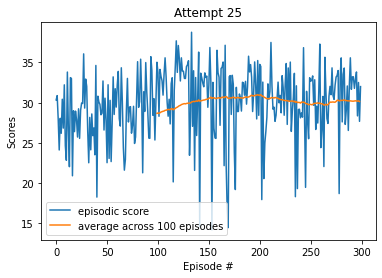

In [9]:
# We run for another 300 episodes looking for a max
scores = ddpg(300, attempt=25)

The maximum average score of 31.0 is attained at epiosde 902.

Episode 100	Average Score: 0.99


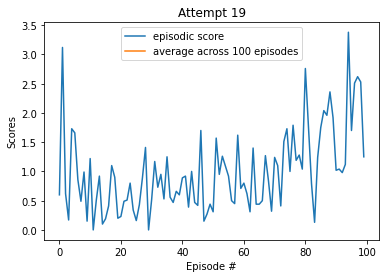

Episode 200	Average Score: 3.55


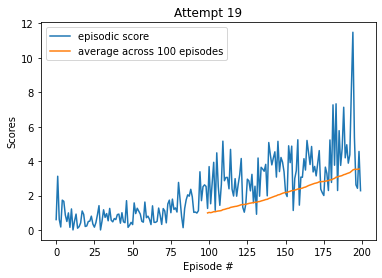

Episode 300	Average Score: 5.32


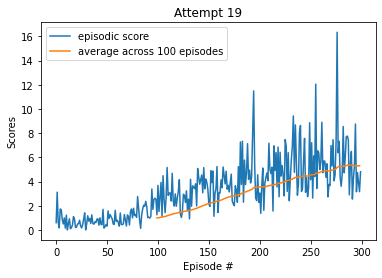

Episode 391	Average Score: 6.36

In [ ]:
# A batch normalization trial, worth to explore parameters of the normalization, did not result in anything spectacular
scores = ddpg(500, attempt=19)

Episode 100	Average Score: 1.47


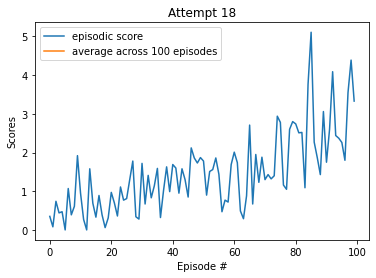

Episode 200	Average Score: 8.65


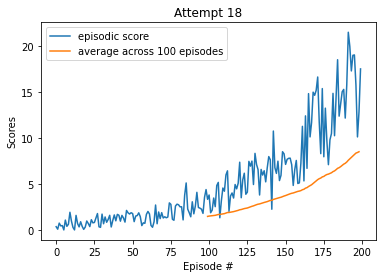

Episode 300	Average Score: 20.97


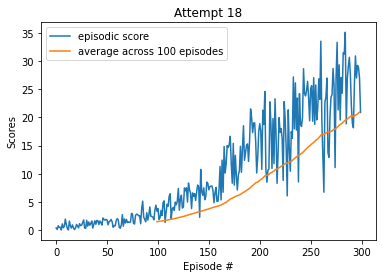

Episode 375	Average Score: 30.07
Environment solved in 275 episodes!	Average Score: 30.07


In [20]:
#  The first successful attempt with the optimal parameters
scores = ddpg(500, attempt=18)

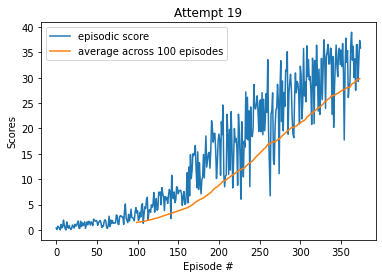

In [22]:
# The number was changed but it is the same as 18
plot_scores(scores, 19, 375)

### 5. Run the trained agent
We now load the weights into an agent instance, and run the trained agent on the environment.

In [5]:
agent = Agent(state_size=33, action_size=4, seed=234)

In [7]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_max.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_max.pth'))

Let us run the environment on the trained agent for 5 episodes.

In [ ]:
n_ep = 5

In [8]:
for ep in range(n_ep):
    score=0
    env_info = env.reset(train_mode=False)[brain_name] 
    while True:
        state = env_info.vector_observations[0]   
        action = agent.act(state, eps=0)       # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break   
    print("Score: {}".format(score))

Score: 32.55999927222729
Score: 39.449999118223786
Score: 31.129999304190278
Score: 34.82999922148883
Score: 37.45999916270375


Clearly, the average is above 30. Finally, do not forget to close the environment so that it is not left hanging!

In [9]:
env.close()